In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         1084 non-null   object 
 1   SeasonNumber                 1084 non-null   int64  
 2   SeasonVersion                1084 non-null   int64  
 3   Player                       1084 non-null   object 
 4   MatchId                      1084 non-null   object 
 5   Map                          1084 non-null   object 
 6   Category                     1084 non-null   object 
 7   Playlist                     1084 non-null   object 
 8   Input                        1084 non-null   object 
 9   Queue                        1084 non-null   object 
 10  PreCsr                       1084 non-null   int64  
 11  PostCsr                      1084 non-null   int64  
 12  WinningTeam                  13 non-null     object 
 13  WinningTeamCSR    

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Ratios
df['Assists/Life'] = df['Assists'] / df['Deaths']
df.loc[df['Assists/Life'] == np.inf, 'Damage/KA'] = df['Assists']
df['Damage/KA'] = df['DamageDone'] / (df['Assists'] + df['Kills'])
df.loc[df['Damage/KA'] == np.inf, 'Damage/KA'] = df['DamageDone']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        807 non-null    int64         
 1   Date                         807 non-null    datetime64[ns]
 2   Map                          807 non-null    object        
 3   Category                     807 non-null    object        
 4   WinningTeam                  12 non-null     object        
 5   WinningTeamCSR               12 non-null     float64       
 6   WinningTeamMMR               12 non-null     float64       
 7   WinningTeamScore             12 non-null     float64       
 8   WinningTeamFinalScore        12 non-null     float64       
 9   WinningTeamWinPercentChance  12 non-null     float64       
 10  LosingTeam                   12 non-null     object        
 11  LosingTeamCSR                12 non-null     

In [4]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,807.0,620.760843,275.158770,140.000000,379.500000,621.000000,864.500000,1.083000e+03
WinningTeamCSR,12.0,935.993056,53.440865,871.000000,906.000000,920.500000,941.916667,1.062250e+03
WinningTeamMMR,12.0,998.141833,53.413630,876.397000,991.296000,1005.561500,1020.030250,1.080840e+03
WinningTeamScore,12.0,8932.916667,2766.274536,5890.000000,6865.000000,8915.000000,9571.250000,1.611000e+04
WinningTeamFinalScore,12.0,14.833333,21.229625,2.000000,2.000000,4.000000,16.250000,5.000000e+01
WinningTeamWinPercentChance,12.0,49.981667,0.238740,49.550000,49.917500,50.010000,50.032500,5.055000e+01
LosingTeamCSR,12.0,933.131944,60.151130,856.000000,905.479167,914.375000,950.375000,1.062000e+03
LosingTeamMMR,12.0,998.916250,54.093920,879.304000,990.837250,1004.399000,1024.680500,1.080167e+03
LosingTeamScore,12.0,7912.083333,3910.956904,4575.000000,5355.000000,6795.000000,9276.250000,1.854000e+04
LosingTeamFinalScore,12.0,11.583333,19.528340,0.000000,0.000000,1.000000,11.500000,4.800000e+01


In [5]:
# dfr.tail()
print(round(dfr.sort_values('Dmg/10Min', ascending=False).iloc[:, :30],2).head(8))


     index                Date        Map          Category WinningTeam  \
727    999 2024-04-07 18:05:50   Recharge           Oddball         NaN   
12     154 2023-10-20 19:33:13   Recharge        Extraction         NaN   
263    455 2023-11-27 22:55:34  Forbidden    CTF 3 Captures         NaN   
729   1001 2024-04-07 18:28:23   Empyrean    CTF 3 Captures         NaN   
310    513 2023-12-01 04:37:03   Solitude       Strongholds         NaN   
420    644 2024-01-18 02:37:59    Streets            Slayer         NaN   
778   1052 2024-04-17 01:10:12   Aquarius    CTF 5 Captures         NaN   
305    502 2023-12-01 02:54:53   Solitude  King of the Hill         NaN   

     WinningTeamCSR  WinningTeamMMR  WinningTeamScore  WinningTeamFinalScore  \
727             NaN             NaN               NaN                    NaN   
12              NaN             NaN               NaN                    NaN   
263             NaN             NaN               NaN                    NaN   
729 

In [6]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

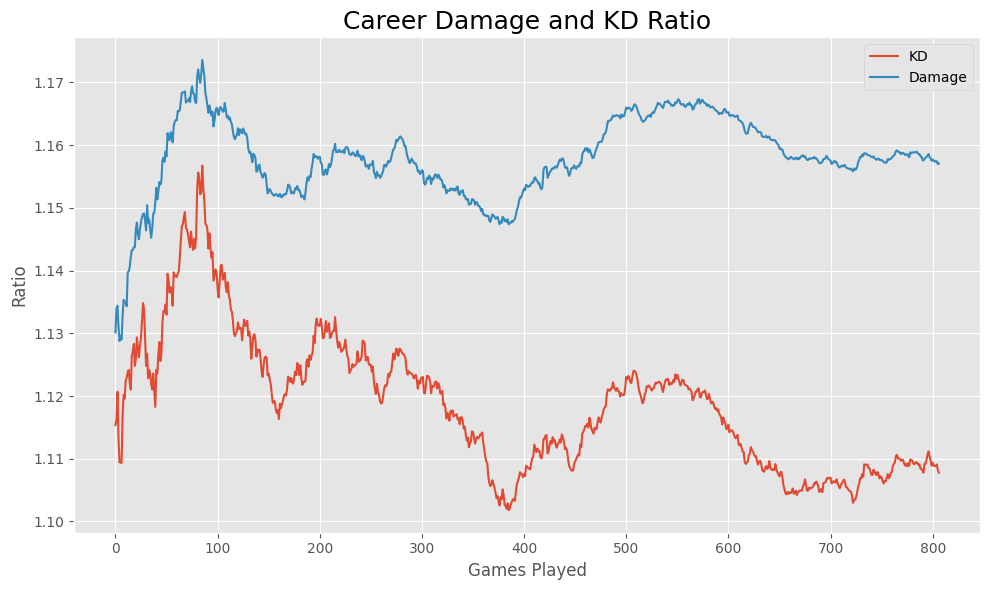

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

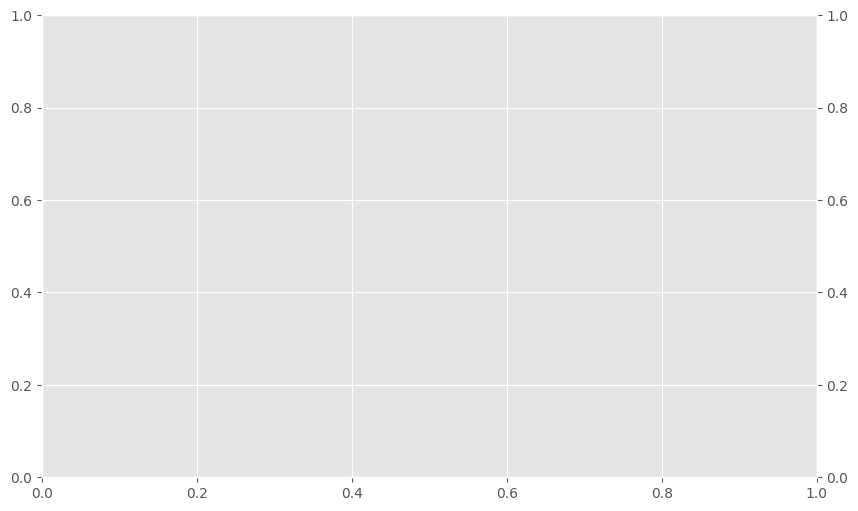

In [8]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

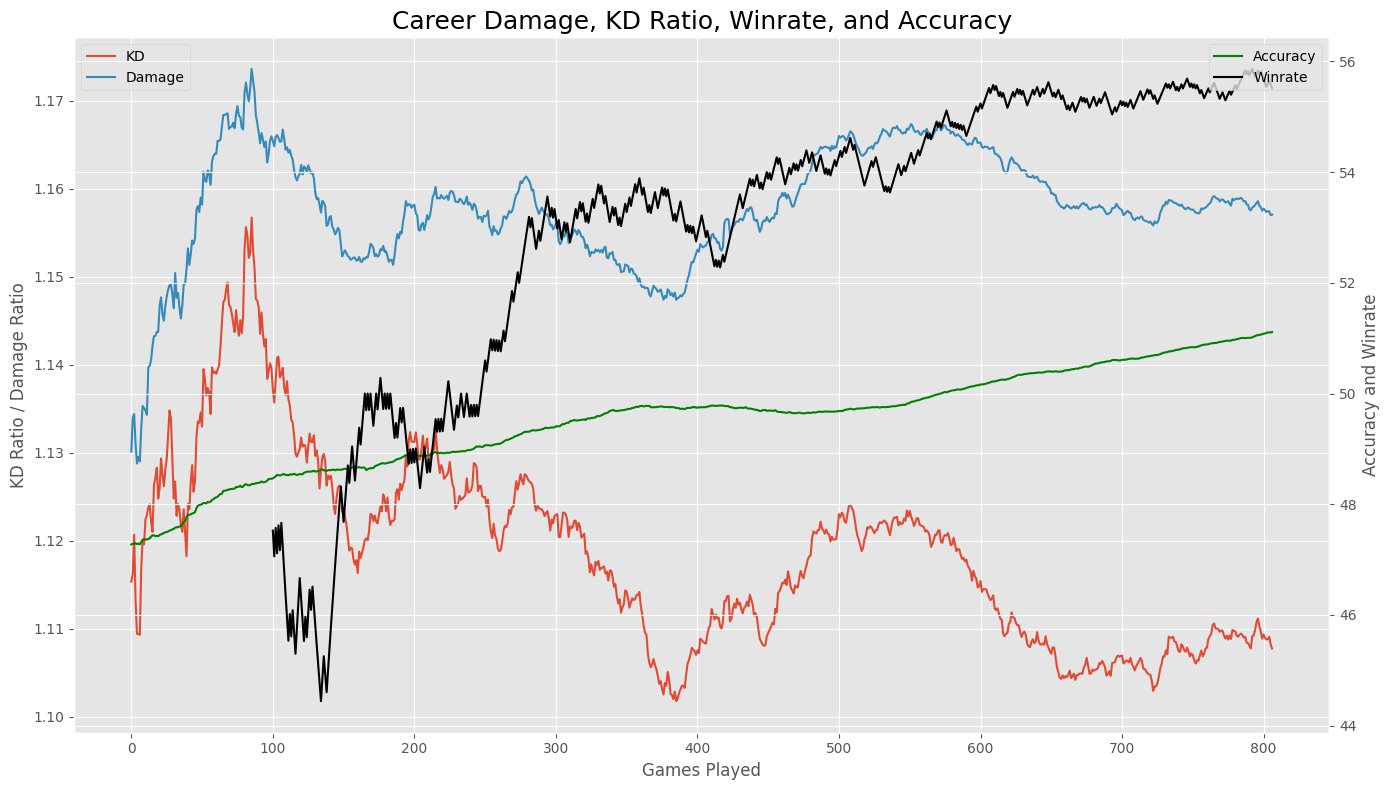

In [9]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

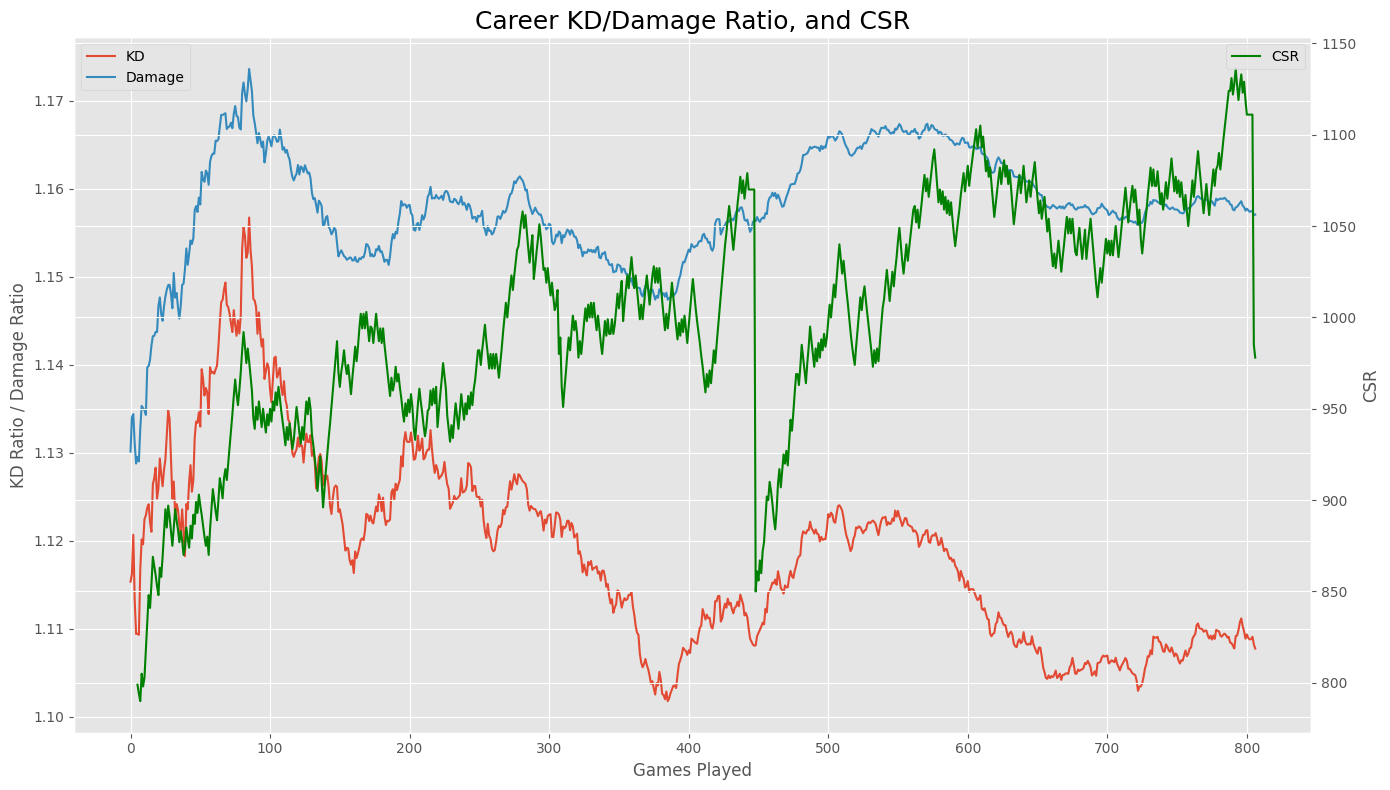

In [10]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

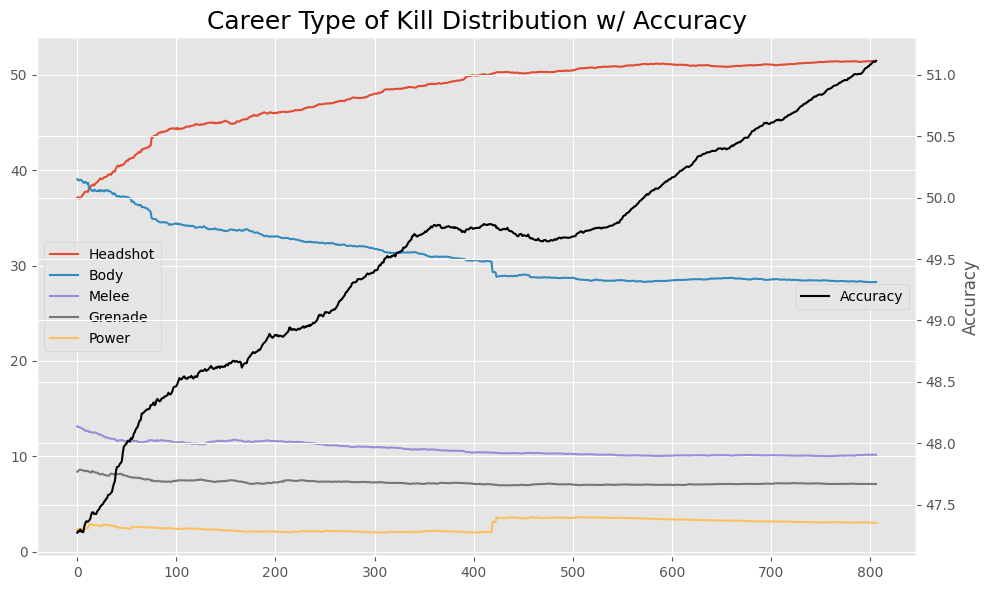

In [11]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

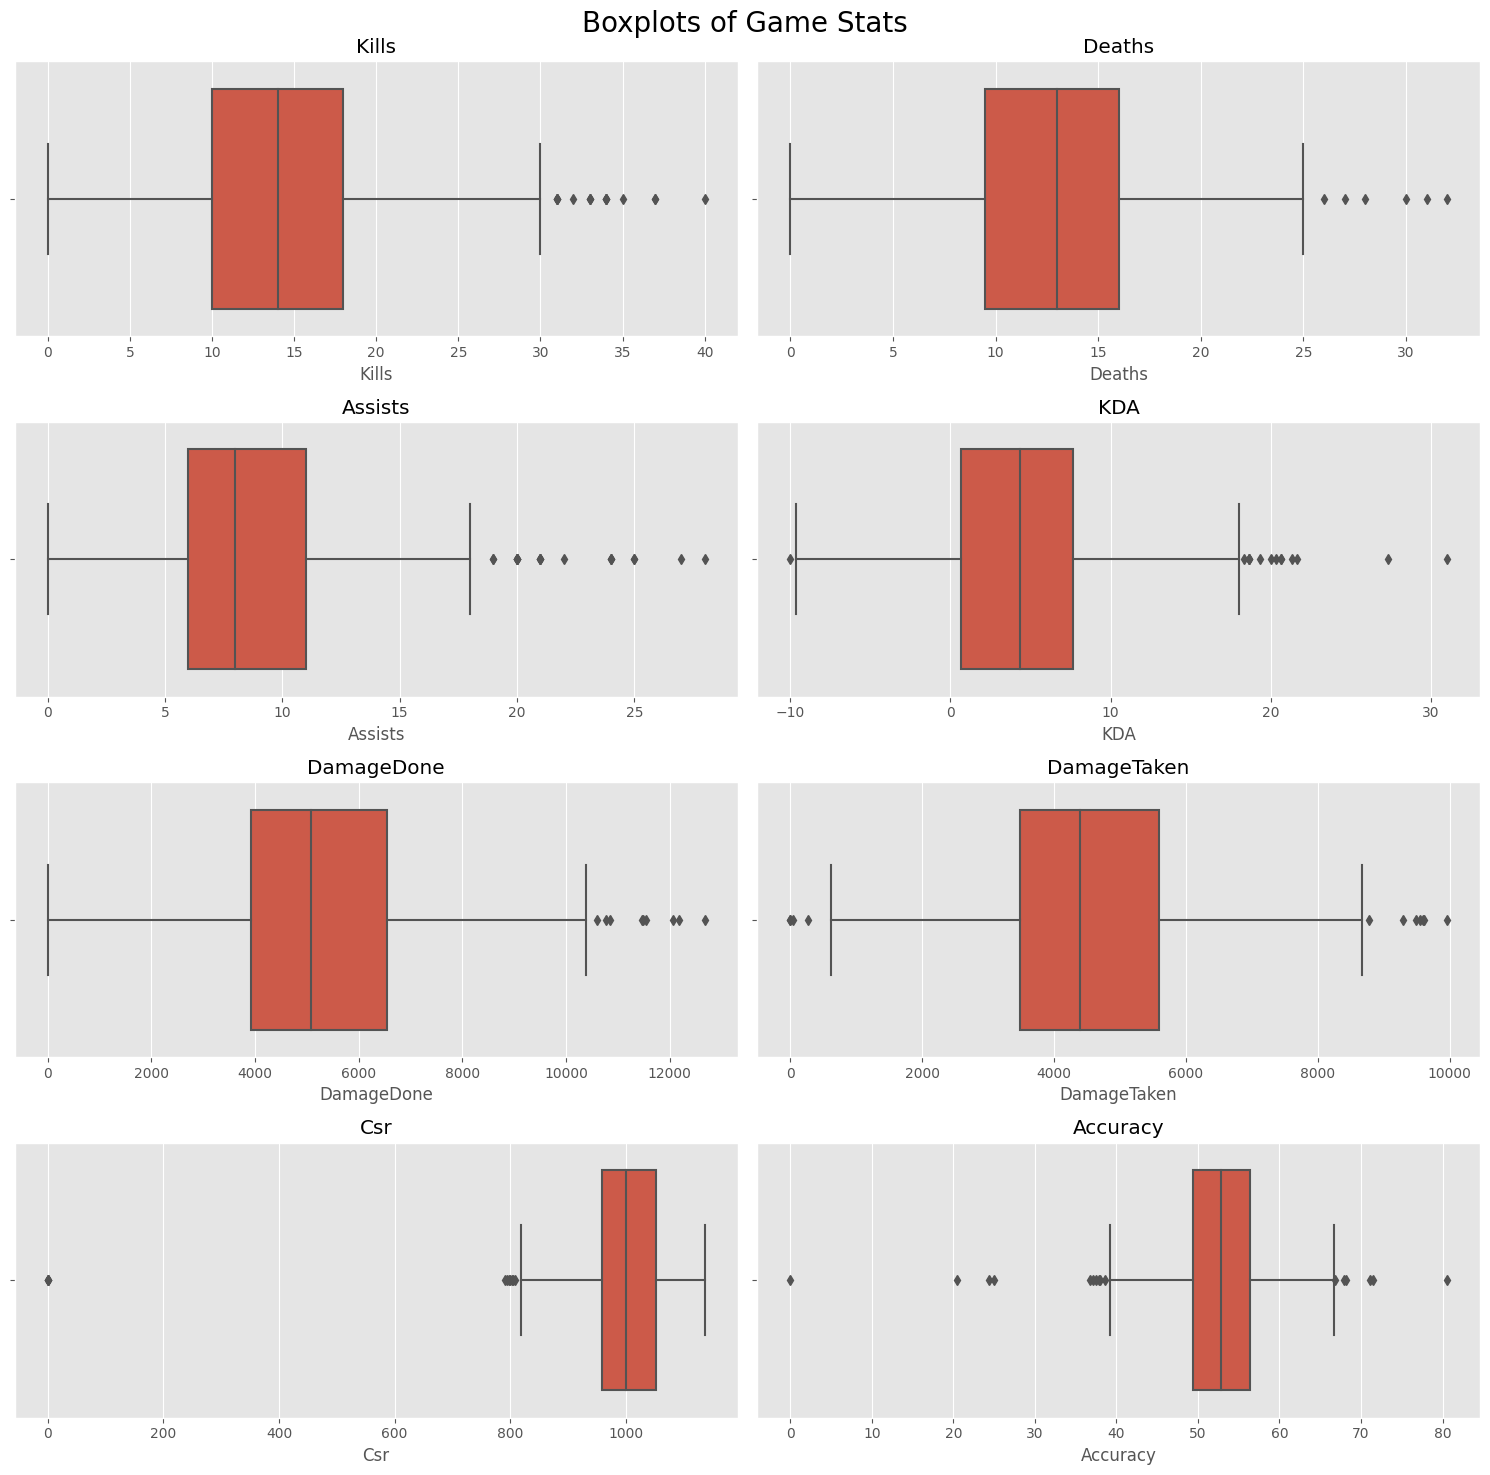

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [13]:
# Last * Games

# mod = 10
# dfmod = dfr.tail(mod)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.25
Accuracy: 53.34
Damage Ratio: 1.25
Win-Loss: 386-240
Winrate: 1.61
Max CSR: 1136


In [14]:
df['Assists/Life'].head(20)

0     0.333333
1     0.636364
2     0.111111
3     1.500000
4     0.666667
5     0.250000
6     0.500000
7     0.333333
8     1.000000
9     0.812500
10    0.200000
11    0.857143
12    0.454545
13    0.666667
14    0.636364
15    0.500000
16    1.333333
17    0.833333
18    0.333333
19    0.650000
Name: Assists/Life, dtype: float64

In [15]:
import plotly.express as px

mod = 10

fig = px.line(dfr, x=dfr.index, y= (dfr['ShotsLanded'].rolling(window=mod).sum() /
                                   dfr['ShotsFired'].rolling(window=mod).sum()*100), 
              labels={'x':"# of Games Played", 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [16]:
import plotly.express as px

mod = 50
name = 'Assists/Life'

fig = px.line(dfr, x=dfr.index, y=(dfr['Assists'].rolling(window=mod).mean() /
                                 dfr['Deaths'].rolling(window=mod).mean()), 
              labels={'x': 'Number of Games Played', 'y': f'{name}'},
              title=f'Rolling Avg {name}')

fig.show()


In [17]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.13
Average Kills: 13.59
Average Deaths: 11.98
Average Assists: 8.09
Average Accuracy: 52.7
Average Damage Done: 5299
Average Damage Taken: 4553
Damage Ratio: 1.16
Dmg Done <> Taken: 626-180
Win-Loss: 448-359
----------------------------
Totals
Total Games: 807
Total Kills: 11764
Total Deaths: 10472
Total Assists: 6965
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.12
Average Deaths: 10.72
Average Assists: 8.54
Average Accuracy: 52.99
Average Damage Done: 5134
Average Damage Taken: 4190
Damage Ratio: 1.23
Wins: 448
----------------------------
Losses
Overall KD: 0.95
Average Kills: 12.93
Average Deaths: 13.56
Average Assists: 7.52
Average Accuracy: 52.36
Average Damage Done: 5505
Average Damage Taken: 5006
Damage Ratio: 1.1
Losses: 359


In [18]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 0
Games Ranked 5: 4
MVP %: 0.5


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [19]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [20]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 9
Scorigami
11-15-8     3
13-11-9     3
15-8-7      3
17-15-9     3
17-16-10    3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [21]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
CTF 3 Captures,1574.30,143,18.43,17.72
Slayer,1541.55,179,18.04,22.18
Oddball,1500.10,123,17.56,15.24
Strongholds,1417.28,121,16.59,14.99
King of the Hill,1342.75,125,15.72,15.49
Extraction,611.85,70,7.16,8.67
CTF 5 Captures,555.98,46,6.51,5.70


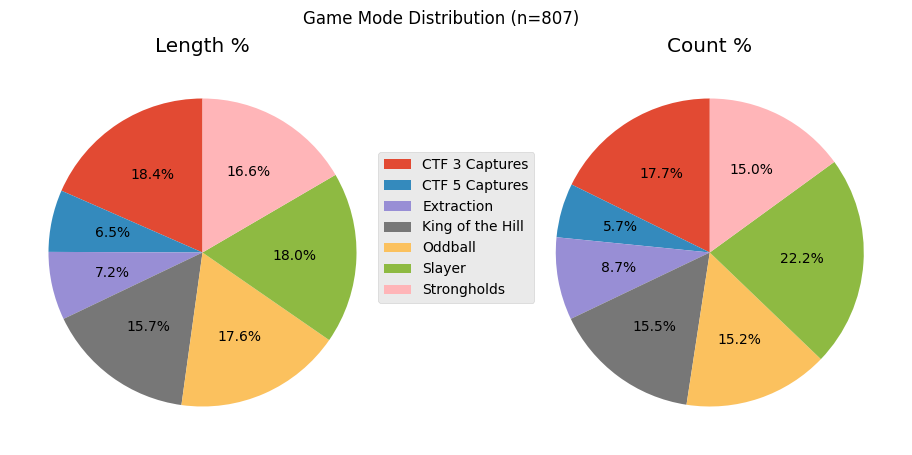

In [22]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [23]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
Oddball,Streets,50,10.42,0.60,6.20,7.32
CTF 3 Captures,Argyle,52,9.95,0.48,6.44,6.99
King of the Hill,Recharge,52,9.71,0.50,6.44,6.82
CTF 5 Captures,Aquarius,46,9.27,0.46,5.70,6.51
Strongholds,Solitude,45,9.20,0.47,5.58,6.46
CTF 3 Captures,Empyrean,47,9.10,0.55,5.82,6.39
Oddball,Recharge,40,7.96,0.60,4.96,5.59
Slayer,Solitude,52,7.72,0.67,6.44,5.42
Strongholds,Recharge,40,7.59,0.50,4.96,5.33


In [24]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)

dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) * 100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min']
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False), 2)
dfrcc

Count  Wins  Losses  Kills  Deaths  Assists  \
Category         Map                                                         
King of the Hill Live Fire        38    27      11    565     526      336   
Slayer           Streets          32    22      10    297     290      213   
                 Solitude         52    35      17    551     550      371   
                 Recharge         17    11       6    162     159      115   
Extraction       Recharge         18    11       7    230     193      143   
Oddball          Live Fire        33    20      13    541     520      340   
Extraction       Streets          33    20      13    453     351      253   
Oddball          Streets          50    30      20    892     808      555   
                 Recharge         40    24      16    659     553      415   
CTF 3 Captures   Empyrean         47    26      21    746     659      378   
Slayer           Aquarius         49    27      22    519     502      326   
CTF 3 Captures   Forbidden        44    24      20    557     462      285   
King of the Hill Solitude         35    19      16    560     471      366   
Strongholds      Recharge         40    20      20    580     575      353   
                 Live Fire        34    17      17    540     471      258   
Slayer           Live Fire        28    14      14    288     287      160   
King of the Hill Recharge         52    26      26    868     772      615   
CTF 3 Captures   Argyle           52    25      27    781     663      376   
Strongholds      Solitude         45    21      24    847     707      507   
CTF 5 Captures   Aquarius         46    21      25    873     690      456   
Extraction       Live Fire        19     8      11    230     216      125   
Strongholds      Interference      2     0       2     18      36       12   
Slayer           Interference      1     0       1      7      11        7   

                               DamageDone  DamageTaken  Winrate  \
Category         Map                                              
King of the Hill Live Fire         201258       181407     0.71   
Slayer           Streets           121584       107561     0.69   
                 Solitude          218266       197390     0.67   
                 Recharge           67949        63215     0.65   
Extraction       Recharge           80159        66596     0.61   
Oddball          Live Fire         198427       170784     0.61   
Extraction       Streets           147191       118482     0.61   
Oddball          Streets           323885       273794     0.60   
                 Recharge          237257       198978     0.60   
CTF 3 Captures   Empyrean          266011       234266     0.55   
Slayer           Aquarius          203708       182609     0.55   
CTF 3 Captures   Forbidden         210149       170799     0.55   
King of the Hill Solitude          196034       162842     0.54   
Strongholds      Recharge          221023       199363     0.50   
                 Live Fire         190571       168723     0.50   
Slayer           Live Fire         107861       103330     0.50   
King of the Hill Recharge          318210       268129     0.50   
CTF 3 Captures   Argyle            280252       233992     0.48   
Strongholds      Solitude          286814       241637     0.47   
CTF 5 Captures   Aquarius          304989       243099     0.46   
Extraction       Live Fire          82363        72351     0.42   
Strongholds      Interference        8902        11167     0.00   
Slayer           Interference        3567         3749     0.00   

                               LengthMinutes  Accuracy    KD  DamageRatio  \
Category         Map                                                        
King of the Hill Live Fire            383.33     55.41  1.07         1.11   
Slayer           Streets              258.78     51.02  1.02         1.13   
                 Solitude             463.35     50.79  1.00         1.11   
                 Re

In [25]:
dfrcc = dfr.groupby('Category').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Slayer,179,109,70,1824,1799,1192,17584,34721,722935,657854,0.61,1541.55,1.01,1.10,401.85,36.18,0.66
Oddball,123,74,49,2092,1881,1310,17256,32363,759569,643556,0.60,1500.10,1.11,1.18,403.81,61.68,0.70
King of the Hill,125,72,53,1993,1769,1317,16512,31097,715502,612378,0.58,1342.75,1.13,1.17,404.47,58.30,0.74
Extraction,70,39,31,913,760,521,7421,13807,309713,257429,0.56,611.85,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,143,75,68,2084,1784,1039,17888,33933,756412,639057,0.52,1574.30,1.17,1.18,424.00,65.78,0.58
Strongholds,121,58,63,1985,1789,1130,16318,30940,707310,620890,0.48,1417.28,1.11,1.14,395.37,48.31,0.63
CTF 5 Captures,46,21,25,873,690,456,7332,13484,304989,243099,0.46,555.98,1.27,1.25,442.01,89.70,0.66


In [26]:
dfrcc = dfr.groupby('Map').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Streets,115,72,43,1642,1449,1021,14129,26231,592660,499837,0.63,1168.40,1.13,1.19,409.01,64.06,0.70
Solitude,132,75,57,1958,1728,1244,16382,31244,701114,601869,0.57,1391.62,1.13,1.16,405.74,57.43,0.72
Live Fire,152,86,66,2164,2020,1219,17697,32766,780480,696595,0.57,1576.18,1.07,1.12,386.38,41.53,0.60
Empyrean,47,26,21,746,659,378,6427,12205,266011,234266,0.55,545.97,1.13,1.14,403.66,48.17,0.57
Recharge,167,92,75,2499,2252,1641,21538,42368,924598,796281,0.55,1834.77,1.11,1.16,410.57,56.98,0.73
Forbidden,44,24,20,557,462,285,4959,9334,210149,170799,0.55,431.25,1.21,1.23,454.87,85.17,0.62
Aquarius,95,48,47,1392,1192,782,12369,23250,508697,425708,0.51,967.93,1.17,1.19,426.76,69.62,0.66
Argyle,52,25,27,781,663,376,6502,12394,280252,233992,0.48,597.08,1.18,1.20,422.70,69.77,0.57
Interference,3,0,3,25,47,19,308,553,12469,14916,0.00,30.62,0.53,0.84,265.30,-52.06,0.40


In [27]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 6.02612266712822s
